In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle
import numpy as np
import xgboost as xgb
import yaml
import seaborn as sns
import mplcursors
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [44]:
file_path_train='../data/train.csv'
df_train = pd.read_csv(file_path_train)
df_train.head()

/tmp/ipykernel_29482/1787693017.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(file_path_train)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [45]:
file_path_store='../data/store.csv'
df_store = pd.read_csv(file_path_store)
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [46]:
# merged on store dataframe : mos_df
mos_df = pd.merge(df_store, df_train, on='Store')
mos_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


In [47]:
# total sales for each store : tsfes_df
# group by the 'Store' and aggregate the sum function on the 'Sales' column 
tsfes_df = mos_df.groupby('Store')['Sales'].sum()
tsfes_df.head()

Store
1    3716854
2    3883858
3    5408261
4    7556507
5    3642818
Name: Sales, dtype: int64

if I train my model with the 10 % of shops then I need to use the same dataset for test also. If not the model can be over fit 

In [48]:
# calculate the top 10% 
# top_ten_percent_stores_on_sales: ttpsos
ttpsos = tsfes_df.quantile(0.9)
top_stores_list = tsfes_df[tsfes_df >= ttpsos].index.tolist()
top_stores_df = mos_df[mos_df['Store'].isin(top_stores_list)]
top_stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
2826,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,5,2015-07-31,13995,1498,1,1,0,1
2827,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,4,2015-07-30,10387,1276,1,1,0,1
2828,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,3,2015-07-29,10514,1258,1,1,0,1
2829,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2,2015-07-28,10275,1191,1,1,0,1
2830,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,1,2015-07-27,11812,1379,1,1,0,1


## Explore the data on Sales and Date


In [49]:
df = top_stores_df.copy()
df['Date'] = pd.to_datetime(df['Date'])

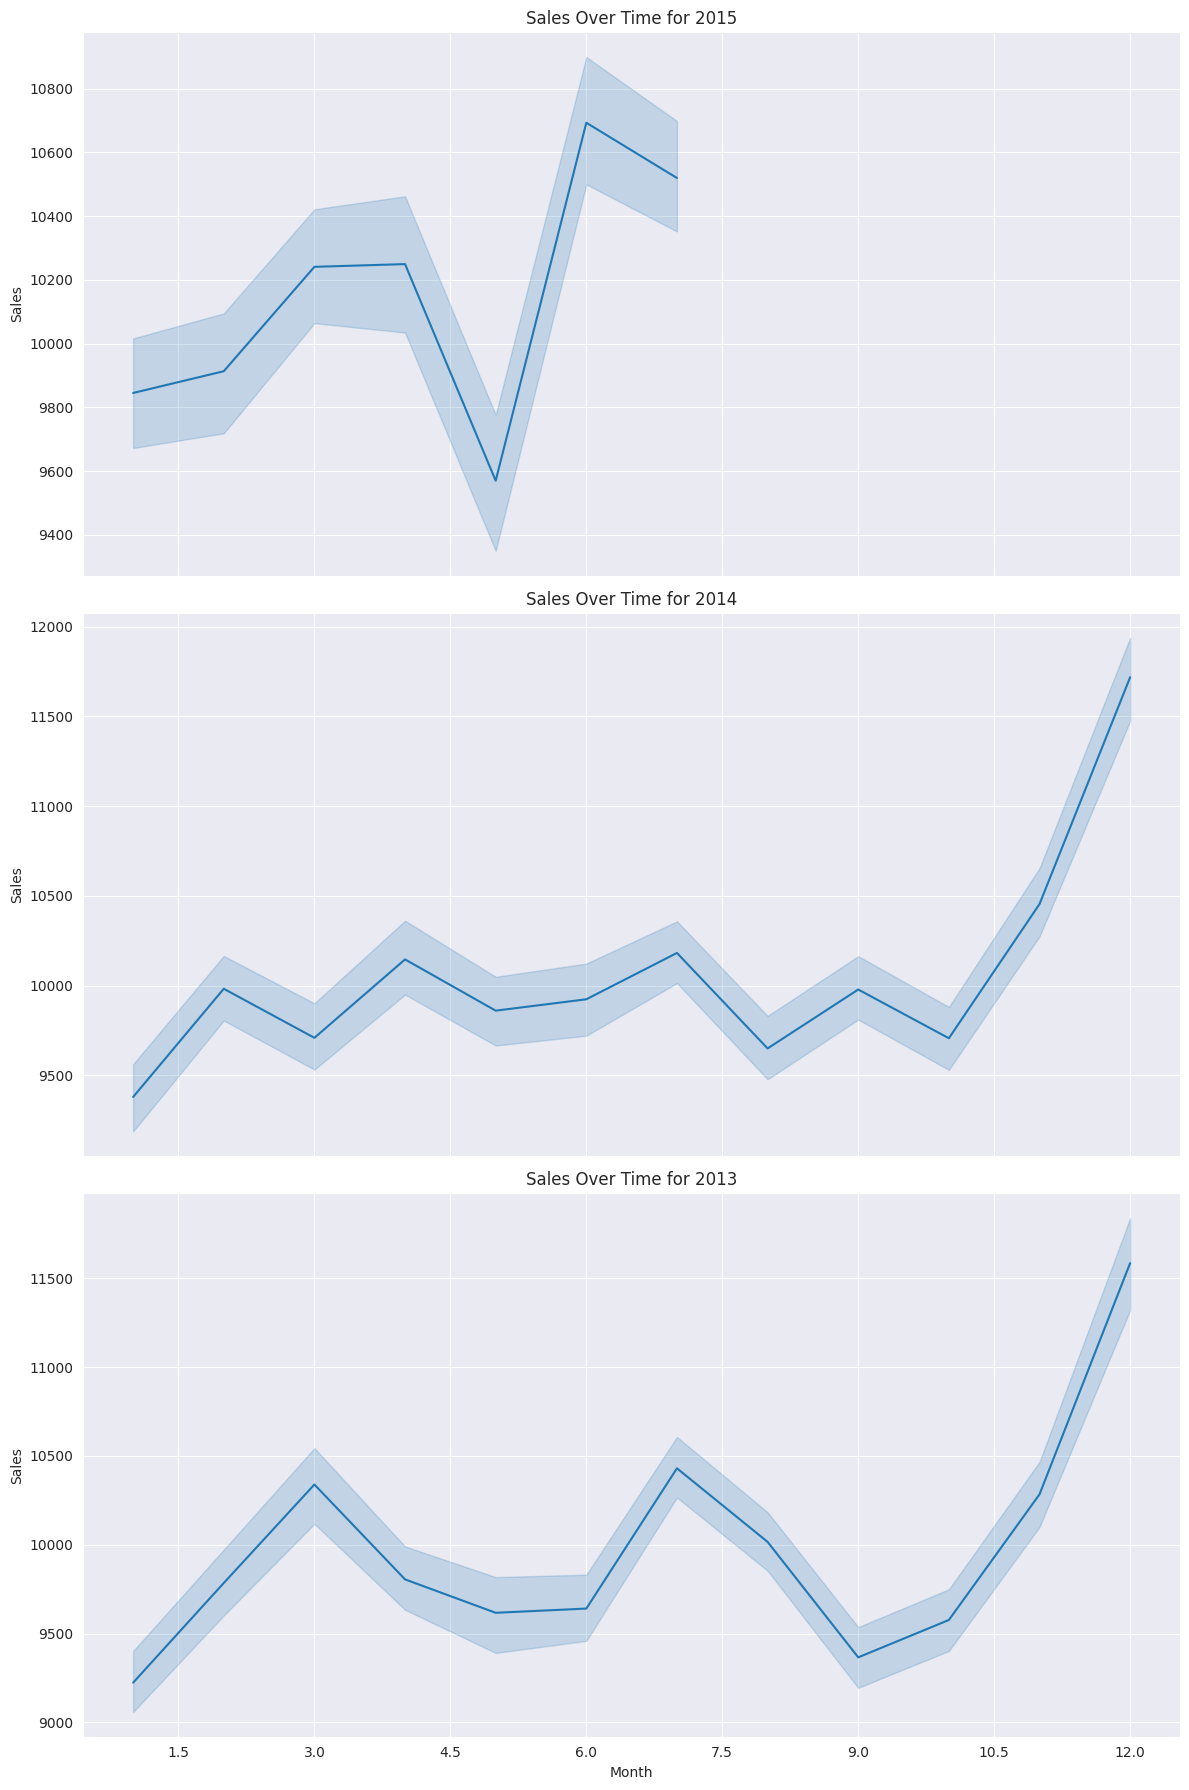

In [50]:

# Assuming 'Date' is not in datetime format, convert it
df['Year'] = df['Date'].dt.year  # Extract the year from the 'Date' column
df['Month'] = df['Date'].dt.month  # Extract the month from the 'Date' column

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plotting using Seaborn for each year
for i, year in enumerate(df['Year'].unique()):
    year_data = df[df['Year'] == year]
    sns.lineplot(x='Month', y='Sales', data=year_data, ax=axs[i])
    axs[i].set_title(f'Sales Over Time for {year}')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Sales')
    axs[i].set_xticks(year_data['Month'].unique())  # Show months on x-axis
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(len(year_data['Month'].unique())))  # Adjust x-axis ticks

# Enable interactive zooming
mplcursors.cursor(hover=True)
plt.tight_layout()
plt.show()


#### 
As we can see the manner of data changes during the year and we have more Sales in march, juli and specially end of the year, to reflect these I am going to decompose the Date in Feature to number of weeks and day of week and use this two features to train my model. 
To tackle the data deeper and understand the manner of sales during the year we can also use some methods like STL to decompose the seasonality and trend and Residual and have more meaningful model to forecast the Sales


## Feature Engineering

In [51]:
df = top_stores_df.copy()
df['Date'] = pd.to_datetime(df['Date'])

#### Plot the Sales Normal Dist in df and Normalize it adn same the min and max to use it later in fastapi

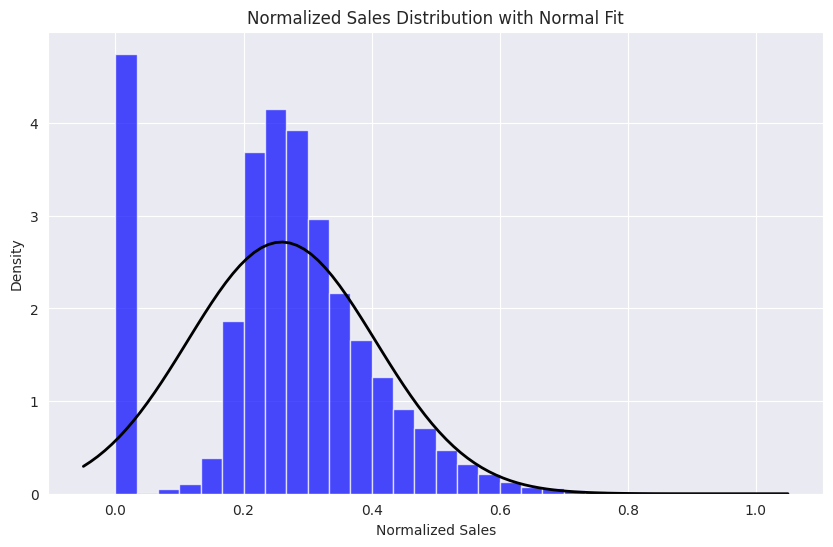

In [52]:
# have a look how looks the normal dist of Sales when it is normalized
min_sales = df['Sales'].min()
max_sales = df['Sales'].max()

# Convert numpy scalars to Python types
min_sales_value = min_sales.item() if hasattr(min_sales, 'item') else min_sales
max_sales_value = max_sales.item() if hasattr(max_sales, 'item') else max_sales

# Create a dictionary
sales_dict = {'min_sales': min_sales_value, 'max_sales': max_sales_value}

# Save the dictionary to a YAML file
yaml_content = yaml.dump(sales_dict, default_flow_style=False)

with open('../config/sales_range.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_content)



# Normalize 'Sales' between 0 and 1
df['Normalized_Sales'] = (df['Sales'] - min_sales) / (max_sales - min_sales)

# Plot the normal distribution diagram
plt.figure(figsize=(10, 6))
plt.hist(df['Normalized_Sales'], bins=30, density=True, alpha=0.7, color='blue')

# Fit a normal distribution to the data
mu, std = norm.fit(df['Normalized_Sales'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Normalized Sales Distribution with Normal Fit')
plt.xlabel('Normalized Sales')
plt.ylabel('Density')
plt.show()

The left skewed distribution is now reasonable for the first iteration of investigation. There are some methods like Logging to improve it, which I tried. they did not give me a desired result. ero Values from our 'Sales' to be able to calculate RMS

### profile the data frame to find the suitable features

In [53]:
profile = ProfileReport(df, title="Profiling Report")
%matplotlib inline

#### Profiling:  the output of reporting as HTML is available in the reports directory. I had a look to understand better the features

In [54]:
# profile.to_file("my_report.json")
# profile.to_file("my_report.html")

highly Correlated Features:

    ##### Promo2,  StoreType, Assortment:
     These features show relatively high correlation with 'Sales'. Consider including them in my model.
    PromoInterval ( can not consider, there are 73% Missing values),

Moderate Correlations:

     ##### CompetitionOpenSinceMonth, CompetitionOpenSinceYear:
      These features have moderate correlation with 'Sales'. I would consider them in my model
      I need to handle Missing values, I am going to simply remove them, there are just ~30% of them
     Promo2SinceWeek, Promo2SinceYear( can not consider, there are 73% Missing values),

Low Correlations:

    ##### DayOfWeek
    have low correlation with 'Sales'. 
    I am just going to use DayOfWeek
    Open, Promo, StateHoliday, SchoolHoliday I do not use them. Just one of Low Correlations is enough for the first iteration

 find the relevant features to train the model
    Store Information:
        StoreType: Categorical variable representing the store type.
        Assortment: Categorical variable representing the assortment type.

    Promotion Information:
        Promo2: Binary variable indicating whether the store is participating in a continuing promotion.

    Date Information:
        DayOfWeek: Categorical variable representing the day of the week.

    Sales Information:
        Sales: Target variable we want to predict.
 

Date: I do not use the Date as an input because each row has its distinct value. We use it just in the APP.
because I use some features like DayOfWeek and WeekNumber which are derivatives of Date,  the need to not use the Date directly as a feature is not so heavy


In [55]:
df['SchoolHoliday'].dtype

dtype('int64')

#### Promo2

In [56]:
# Store Type 
print(df['Promo2'].dtype)
print(df['Promo2'].unique())

int64
[0 1]


In [57]:
print(df['Promo2'].isna().sum())

0


#### Store Type

In [58]:
# Store Type 
print(df['StoreType'].dtype)
print(df['StoreType'].unique())


object
['c' 'd' 'a' 'b']


In [59]:
#check the NA in this column
print(df['StoreType'].isna().sum())

0


In [60]:
# since the order of data does not matter I use simple mapping
store_type_mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
df.loc[:, 'StoreType'] = df['StoreType'].map(store_type_mapping).fillna(0).astype(int)

#### Assortment

In [61]:
# Assortment is a categorical data type so we need to convert it to numerical
print(df['Assortment'].dtype)
print(df['Assortment'].unique())


object
['c' 'a' 'b']


In [62]:
#check the NA in this column
print(df['Assortment'].isna().sum())

0


In [63]:
# label encoder to convert a categorical column to a numerical column

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Assortment' column
df['Assortment'] = label_encoder.fit_transform(df['Assortment'])
print(df['Assortment'].unique())

[2 0 1]


#### CompetitionOpenSinceMonth, CompetitionOpenSinceYear

In [64]:
print(df['CompetitionOpenSinceMonth'].dtype)
df.dropna(subset=['CompetitionOpenSinceMonth'], inplace=True)
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].astype(int)
print(df['CompetitionOpenSinceMonth'].unique())
print(df['CompetitionOpenSinceMonth'].dtype)

float64
[ 9  4 10  6  8 12 11  5  2  7  3  1]
int64


In [65]:
print(df['CompetitionOpenSinceYear'].dtype)
df.dropna(subset=['CompetitionOpenSinceYear'], inplace=True)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].astype(int)
print(df['CompetitionOpenSinceYear'].unique())
print(df['CompetitionOpenSinceYear'].dtype)

float64
[2009 2003 2000 2014 2005 2004 2006 2015 2013 2001 2012 2010 2011 2008
 2002 2007 1999]
int64


In [66]:
df['CompetitionOpenSince'] = df['CompetitionOpenSinceYear'] * 100 + df['CompetitionOpenSinceMonth']
print(df['CompetitionOpenSince'].unique())

[200909 200304 200010 201406 201408 200906 200512 200410 200611 200509
 201504 201305 200108 201209 201002 201407 200310 200504 201108 200904
 201206 201405 200911 201412 200903 200804 200202 201308 201311 201309
 201008 200112 200605 200501 201307 200902 200810 201003 201506 201411
 200708 200609 201105 201012 201106 199910 200312 201303 200603 200706
 200711 200604 200508 201007 201104 201403 200806 201310 200905 200007
 200203]


In [67]:
# I decided not use this features because they do not have any effect on the model performance
df = pd.get_dummies(df, columns=['CompetitionOpenSinceMonth'], prefix='CompMonth', drop_first=True)
comp_month_columns = [col for col in df.columns if col.startswith('CompMonth')]
print(df[comp_month_columns])

         CompMonth_2  CompMonth_3  CompMonth_4  CompMonth_5  CompMonth_6  \
2826           False        False        False        False        False   
2827           False        False        False        False        False   
2828           False        False        False        False        False   
2829           False        False        False        False        False   
2830           False        False        False        False        False   
...              ...          ...          ...          ...          ...   
1014378        False        False         True        False        False   
1014379        False        False         True        False        False   
1014380        False        False         True        False        False   
1014381        False        False         True        False        False   
1014382        False        False         True        False        False   

         CompMonth_7  CompMonth_8  CompMonth_9  CompMonth_10  CompMonth_11  \
2826     

#### Deal with 'Date'

In [68]:
# I am going to use weeknumber as a new feature to see the result
df['WeekNumber'] = df['Date'].dt.isocalendar().week.astype('int32')

In [69]:
unique_week_number = df['WeekNumber'].unique()

print("Unique values for 'WeekNumber':", unique_week_number)

Unique values for 'WeekNumber': [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36
 35 34 33 32]


In [70]:
df['WeekNumber'].head()

2826    31
2827    31
2828    31
2829    31
2830    31
Name: WeekNumber, dtype: int32

For the second iteration I would tackle the combined features to combine the SchoolHolday and StateHoliday with DayOfWeek and which could be a very nice feature to be used in the model

## Select the X and y and train the Models

##### I need to remove the Zero values from y to be able to calculate the RMSPE

In [71]:
columns_list = df.columns.tolist()

print(columns_list)

['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Normalized_Sales', 'CompetitionOpenSince', 'CompMonth_2', 'CompMonth_3', 'CompMonth_4', 'CompMonth_5', 'CompMonth_6', 'CompMonth_7', 'CompMonth_8', 'CompMonth_9', 'CompMonth_10', 'CompMonth_11', 'CompMonth_12', 'WeekNumber']


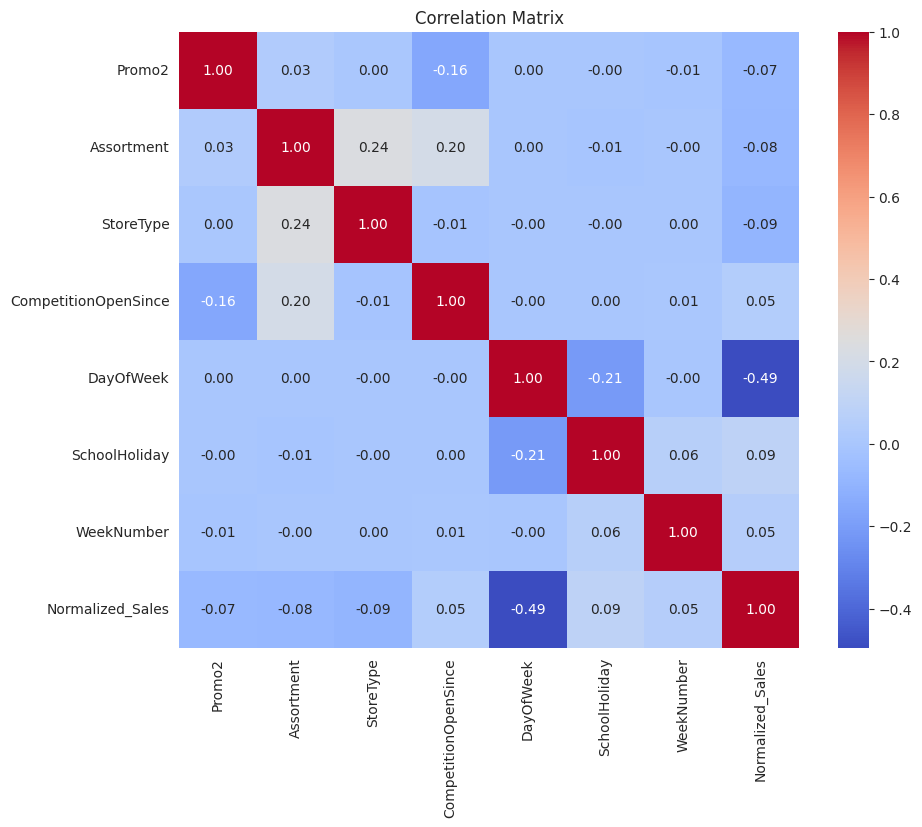

In [72]:
# let's have a look at the correlation matrix of important features
X = df[['Promo2','Assortment', 'StoreType', 'CompetitionOpenSince', 'DayOfWeek', 'SchoolHoliday','WeekNumber']]
y = df['Normalized_Sales']

# Concatenate X and y to create a DataFrame for correlation calculation
data_for_corr = pd.concat([X, y], axis=1)

# Calculate correlation matrix
corr_matrix = data_for_corr.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

##### Remove the Zeros from Sales

In [73]:
df = df[df['Normalized_Sales'] != 0]

##### Select all features in X and Goal in y
##### I trained several model but finally I just let the linearRegression and XGBoost to stay in the final draft . 
##### and I am going to save the LinearRegression model to be used in FAST API

In [74]:

X = df[['Promo2','Assortment', 'StoreType', 'DayOfWeek', 'SchoolHoliday','WeekNumber']]
# Get the list of new one-hot encoded columns
# one_hot_cols = df.filter(regex='^CompMonth').columns.tolist()

# Add the new one-hot encoded columns to X
# X  = pd.concat([X, df[one_hot_cols]], axis=1)

column_names = X.columns.tolist()

y = df['Normalized_Sales']

def normalize_features(X):
    scaler = MinMaxScaler()
    X_normalized_pandas = pd.DataFrame(scaler.fit_transform(X), columns=column_names)
    return X_normalized_pandas

normalized_X = normalize_features(X)
X = normalized_X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Regression Model initialization and train

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

# prediction on the test data
y_pred = model_reg.predict(X_test)

In [75]:
X_pds = pd.DataFrame(X)
# Now you can use head()
print(X_pds.head())
print(X_pds.columns.tolist())

   Promo2  Assortment  StoreType  DayOfWeek  SchoolHoliday  WeekNumber
0     0.0         1.0   0.666667   0.666667            1.0    0.588235
1     0.0         1.0   0.666667   0.500000            1.0    0.588235
2     0.0         1.0   0.666667   0.333333            1.0    0.588235
3     0.0         1.0   0.666667   0.166667            1.0    0.588235
4     0.0         1.0   0.666667   0.000000            1.0    0.588235
['Promo2', 'Assortment', 'StoreType', 'DayOfWeek', 'SchoolHoliday', 'WeekNumber']


In [76]:
# calculate RMSPE

rmspe = np.sqrt(np.mean(((y_test - y_pred) / y_test ) ** 2)) * 100

mse = mean_squared_error(y_test, y_pred)

# check, ob der RMSPE <= 0.4 ist
if rmspe <= 0.4:
    print(f'RMSPE: {rmspe:.2f}, MSE: {mse:.2f} (Performance ist akzeptabel)')
else:
    print(f'RMSPE: {rmspe:.2f}, MSE: {mse:.2f} (Performance ist nicht akzeptabel)')

RMSPE: 35.32, MSE: 0.01 (Performance ist nicht akzeptabel)


In [77]:

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error: {mse}')
rmspe_xgb = np.sqrt(np.mean(((y_test - y_pred_xgb) / y_test ) ** 2)) * 100
print(f'RMSPE: {rmspe_xgb:.2f}, MSE: {mse_xgb:.2f}')

Mean Squared Error: 0.009333257289437225
RMSPE: 29.64, MSE: 0.01


#### Save the trained Model to the desired directory 

In [78]:
import os
file_path = '../models/maziyar_regression_model.pkl'

# Check if the file exists, and remove it if it does
if os.path.exists(file_path):
    os.remove(file_path)

# Save the model to the file
with open(file_path, 'wb') as file:
    pickle.dump(model_reg, file)

##### a try for grid search for hyper parameter tuning 

In [79]:


# Assuming X_train, X_test, y_train, y_test are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
ridge_model = Ridge()

# Define the hyperparameter grid to search
#param_grid = {'alpha': [0.1, 1, 10, 100]}
# param_grid = {'alpha': [1, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8, 2]}
# Best alpha: 1.3
param_grid = {'alpha': [1.33,1.36, 1.37, 1.38, 1.39, 1.40]}


# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Create a new Ridge model with the best hyperparameters
best_model = Ridge(alpha=best_alpha)

# Train the model on the full training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Best alpha: {best_alpha}")
print(f"Mean Squared Error: {mse}")

rmspe = np.sqrt(np.mean(((y_test - y_pred) / y_test ) ** 2)) * 100
print(f'RMSPE: {rmspe:.2f}, MSE: {mse:.2f}')

Best alpha: 1.4
Mean Squared Error: 0.009333275686210242
RMSPE: 35.32, MSE: 0.01


# DRAFT CELLS

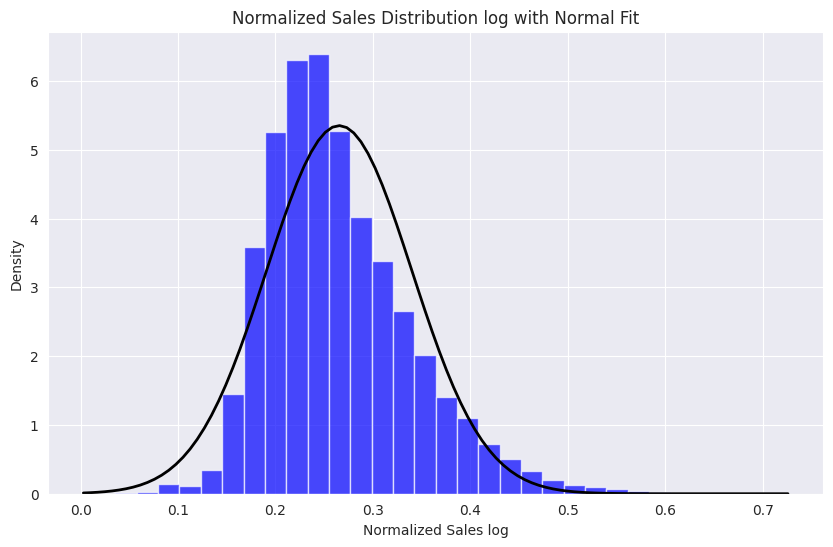

In [80]:
y_log = np.log1p(y)
# Plot the normal distribution diagram
plt.figure(figsize=(10, 6))
plt.hist(y_log, bins=30, density=True, alpha=0.7, color='blue')

# Fit a normal distribution to the data
mu, std = norm.fit(y_log)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Normalized Sales Distribution log with Normal Fit')
plt.xlabel('Normalized Sales log')
plt.ylabel('Density')
plt.show()

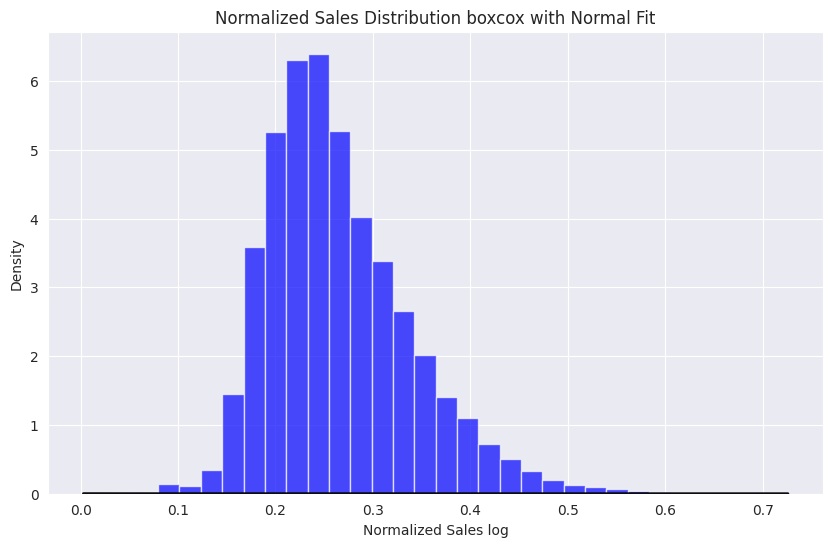

In [81]:
from scipy.stats import boxcox
y_boxcox, _ = boxcox(y)
# Plot the normal distribution diagram
plt.figure(figsize=(10, 6))
plt.hist(y_log, bins=30, density=True, alpha=0.7, color='blue')

# Fit a normal distribution to the data
mu, std = norm.fit(y_boxcox)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Normalized Sales Distribution boxcox with Normal Fit')
plt.xlabel('Normalized Sales log')
plt.ylabel('Density')
plt.show()

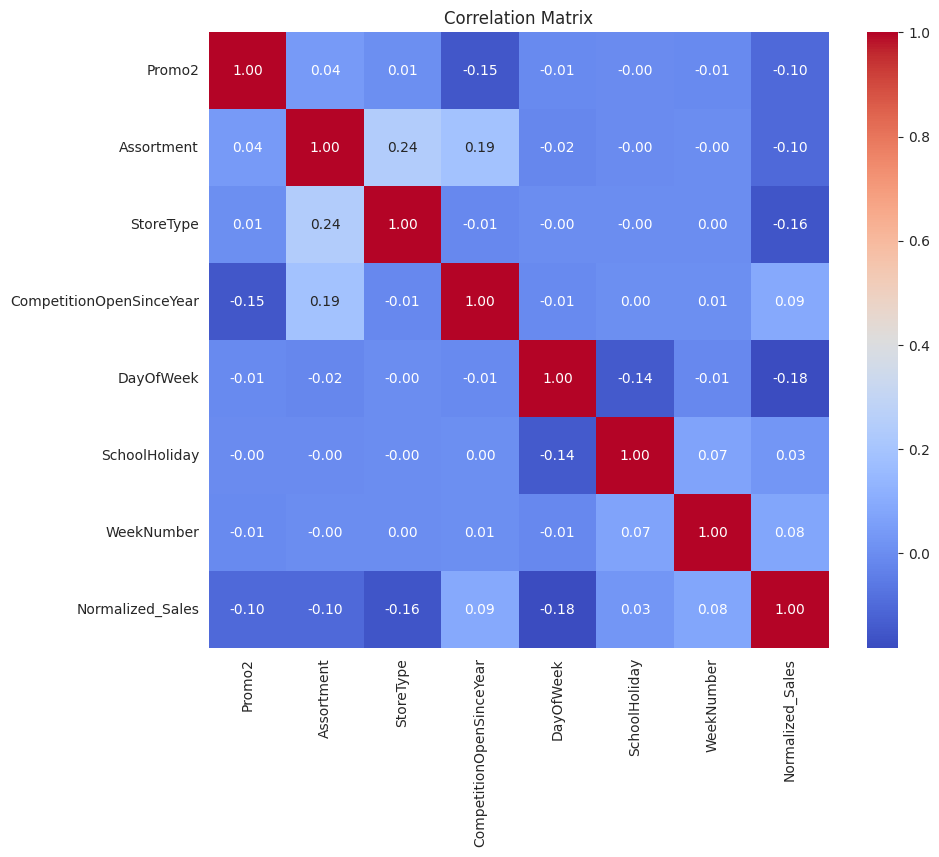

In [82]:


# Assuming df is your DataFrame, X are the features, and y is the target
X = df[['Promo2','Assortment', 'StoreType', 'CompetitionOpenSinceYear', 'DayOfWeek', 'SchoolHoliday','WeekNumber']]
y = df['Normalized_Sales']

# Concatenate X and y to create a DataFrame for correlation calculation
data_for_corr = pd.concat([X, y], axis=1)

# Calculate correlation matrix
corr_matrix = data_for_corr.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [83]:
print(corr_matrix)

                            Promo2  Assortment  StoreType  \
Promo2                    1.000000    0.040374   0.006579   
Assortment                0.040374    1.000000   0.239708   
StoreType                 0.006579    0.239708   1.000000   
CompetitionOpenSinceYear -0.153509    0.187344  -0.014551   
DayOfWeek                -0.010664   -0.017149  -0.000345   
SchoolHoliday            -0.002389   -0.002312  -0.001694   
WeekNumber               -0.008998   -0.001415   0.000774   
Normalized_Sales         -0.101079   -0.099592  -0.158077   

                          CompetitionOpenSinceYear  DayOfWeek  SchoolHoliday  \
Promo2                                   -0.153509  -0.010664      -0.002389   
Assortment                                0.187344  -0.017149      -0.002312   
StoreType                                -0.014551  -0.000345      -0.001694   
CompetitionOpenSinceYear                  1.000000  -0.009466       0.003422   
DayOfWeek                                -0.009466

In [84]:
zero_count = (y_test == 0).sum()
print(f'Number of zero values in y_test: {zero_count}')

Number of zero values in y_test: 0
